In [1]:
# importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import joblib
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

### 1. Preprocessing Data

In [2]:
    # load only neck-sensor data and Behavior_1 needed in the analysis
    sensor_path = r"C:\Users\olayi\Downloads\data (1).csv"  # input the path where the data is saved in your computer
    sensor_cols = ['DogID', 'ANeck_x', 'ANeck_y', 'ANeck_z', 'GNeck_x', 'GNeck_y', 'GNeck_z', 'Behavior_1']
    sensor_data = pd.read_csv(sensor_path, usecols=sensor_cols)
    sensor_data.head()

,DogID,ANeck_x,ANeck_y,ANeck_z,GNeck_x,GNeck_y,GNeck_z,Behavior_1
0,16,-0.067871,-0.510254,-0.934570,-7.934571,6.347657,13.427735,<undefined>
1,16,-0.128906,-0.494141,-0.913086,-3.906250,4.394532,16.540528,Synchronization
2,16,-0.158691,-0.480469,-0.911133,-0.488281,-1.953125,26.794435,Synchronization
3,16,-0.122070,-0.486816,-0.880371,1.159668,-5.676270,38.085940,Synchronization
4,16,-0.053711,-0.500000,-0.807129,4.577637,4.089356,41.503909,Synchronization


In [3]:
# Clean data
# Select only rows without missing values, 'undefined and synchronization' values in Behavior_1 column

# select  data without missing values
sensor_data = sensor_data[sensor_data['Behavior_1'].notna()]

# filter out 'undefined' and 'synchronization' values
sensor_data = sensor_data[~sensor_data['Behavior_1'].isin(['<undefined>', 'Synchronization', 'Extra_Synchronization'])]

print(sensor_data.head())

      DogID   ANeck_x   ANeck_y   ANeck_z    GNeck_x    GNeck_y    GNeck_z  \
9081     16 -0.394043 -0.187500 -0.801270 -11.718751  52.185062 -75.378423   
9082     16 -0.418457 -0.088867 -0.817383  -5.493164  55.969242 -67.749028   
9083     16 -0.440918 -0.052246 -0.799316  -2.990723  54.016117 -55.236820   
9084     16 -0.457520 -0.034668 -0.791504   4.333496  47.058108 -38.940432   
9085     16 -0.445313 -0.052734 -0.791504  13.427735  33.508303 -23.315431   

     Behavior_1  
9081    Walking  
9082    Walking  
9083    Walking  
9084    Walking  
9085    Walking  


In [4]:
# load dog info data
doginfo_path = r"C:\Users\olayi\Downloads\DogInfo.xlsx"  # input the path where the data is saved in your computer
doginfo = pd.read_excel(doginfo_path)
    
# normalize the numerical columns to have mean range 0 and 1
doginfo['Weight'] /= doginfo['Weight'].max()
doginfo['Age months'] /= doginfo['Age months'].max()
    
# One-hot encode breed, gender, neutering status
doginfo = pd.get_dummies(doginfo, columns=['Breed', 'Gender', 'NeuteringStatus'])
    

doginfo.head()

,DogID,Weight,Age months,Breed_Australian Kelpie,Breed_Beauceron,Breed_Belgian Shepherd,Breed_Belgian Shepherd Groenendael,Breed_Belgian Shepherd Malinois,Breed_Border Collie,Breed_Bouvier,...,Breed_Mudi,Breed_Nova Scotia Duck Tolling Retriever,Breed_Smooth Collie,Breed_Spanish Water Dog,Breed_Standard Poodle,Breed_Vizsla,Gender_1,Gender_2,NeuteringStatus_0,NeuteringStatus_1
0,16,0.317073,0.172414,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18,0.707317,0.655172,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,19,0.731707,0.491379,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,20,0.365854,0.405172,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
4,21,0.951220,0.163793,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [5]:
# merge the sensor data and dog info data
full_df = pd.merge(sensor_data, doginfo, on='DogID', how='left')


In [6]:
# Check the dataset shape
print(full_df.shape)

(6556827, 40)


In [7]:
# check the dataset information
print(full_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6556827 entries, 0 to 6556826
Data columns (total 40 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   DogID                                     int64  
 1   ANeck_x                                   float64
 2   ANeck_y                                   float64
 3   ANeck_z                                   float64
 4   GNeck_x                                   float64
 5   GNeck_y                                   float64
 6   GNeck_z                                   float64
 7   Behavior_1                                object 
 8   Weight                                    float64
 9   Age months                                float64
 10  Breed_Australian Kelpie                   uint8  
 11  Breed_Beauceron                           uint8  
 12  Breed_Belgian Shepherd                    uint8  
 13  Breed_Belgian Shepherd Groenendael        uint8  
 14  Br

In [8]:
# Checking the class distribution
print(full_df['Behavior_1'].value_counts())

Lying chest        1031301
Sniffing           1026178
Playing             862571
Panting             836062
Walking             728930
Trotting            717593
Sitting             509412
Standing            448691
Eating              166210
Pacing               77104
Drinking             64721
Shaking              41234
Carrying object      17951
Tugging              13664
Galloping            10828
Jumping               3859
Bowing                 518
Name: Behavior_1, dtype: int64


In [9]:
# window data into sequence
def create_sequences_with_metadata(df, window_size=100, step=25):
    sequences, meta_features, labels = [], [], []
    
    feature_cols = ['ANeck_x', 'ANeck_y', 'ANeck_z', 'GNeck_x', 'GNeck_y', 'GNeck_z']
    static_cols = [col for col in df.columns if col not in feature_cols + ['DogID', 'Behavior_1']]

    for i in range(0, len(df) - window_size, step):
        window = df.iloc[i:i+window_size]
        label = window['Behavior_1'].iloc[window_size // 2] 

        if label not in ['<undefined>', 'Synchronization', 'Extra_Synchronization']:
            sequences.append(window[feature_cols].values)
            meta_features.append(window[static_cols].iloc[0].values)  # same dog info
            labels.append(label)

    return np.array(sequences), np.array(meta_features), np.array(labels)

X_seq, X_meta, y = create_sequences_with_metadata(full_df)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)


# Save for model use
joblib.dump(le, 'labelEncoder.pkl')


['labelEncoder.pkl']

### 2. Model Training

In [10]:
# Creating a subset of the data to work on
X_seq_subset, _, X_meta_subset, _, y_subset, _ = train_test_split(
    X_seq, X_meta, y_encoded,
    train_size=100000,
    stratify=y_encoded,
    random_state=42
)

# Split into train and test sets
X_seq_train, X_seq_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    X_seq, X_meta, y_encoded, test_size=0.2, random_state=42, stratify=y)


# standardize data
scaler_seq = StandardScaler()
# Reshape X_seq_train and X_seq_test for scaling
original_shape_train = X_seq_train.shape
X_seq_train_reshaped = X_seq_train.reshape(-1, original_shape_train[-1])
X_seq_train_scaled = scaler_seq.fit_transform(X_seq_train_reshaped)
X_seq_train = X_seq_train_scaled.reshape(original_shape_train)

original_shape_test = X_seq_test.shape
X_seq_test_reshaped = X_seq_test.reshape(-1, original_shape_test[-1])
X_seq_test_scaled = scaler_seq.transform(X_seq_test_reshaped)
X_seq_test = X_seq_test_scaled.reshape(original_shape_test)


scaler_meta = StandardScaler()
X_meta_train = scaler_meta.fit_transform(X_meta_train)
X_meta_test = scaler_meta.transform(X_meta_test)



# Save test set for later prediction
np.save('C:/Users/olayi/Downloads/X_seq_test.npy', X_seq_test)
np.save('C:/Users/olayi/Downloads/X_meta_test.npy', X_meta_test)
np.save('C:/Users/olayi/Downloads/y_test.npy', y_test)

# safe scaler
joblib.dump(scaler_seq, "scaler_seq.pkl")
joblib.dump(scaler_meta, "scaler_meta.pkl")


In [11]:
# Handling Class Imbalance
# creating a balanced dataset using oversampling

# Flatten X_seq for oversampling
# Flatten and combine training data
X_seq_flat = X_seq_train.reshape(X_seq_train.shape[0], -1)
X_train_combined = np.hstack([X_seq_flat, X_meta_train])

# Apply oversampling only to training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

# Re-split back
seq_len = X_seq_train.shape[1] * X_seq_train.shape[2]
X_seq_train_final = X_train_resampled[:, :seq_len].reshape(-1, X_seq_train.shape[1], X_seq_train.shape[2])
X_meta_train_final = X_train_resampled[:, seq_len:]


In [12]:
# save the resampled seq and meta train set 
np.save('C:/Users/olayi/Downloads/X_seq_train.npy', X_seq_train_final)
np.save('C:/Users/olayi/Downloads/X_meta_train.npy', X_meta_train_final)
np.save('C:/Users/olayi/Downloads/y_train.npy', y_train_resampled)

In [13]:
# Load preprocessed arrays
X_seq_train = np.load('C:/Users/olayi/Downloads/X_seq_train.npy').astype(np.float32)
X_meta_train = np.load('C:/Users/olayi/Downloads/X_meta_train.npy').astype(np.float32)
y_train = np.load('C:/Users/olayi/Downloads/y_train.npy').astype(np.int64)


In [14]:
# Define hybrid model
# Build a 1-Dimensional Convolutional Neural Network
# Combining with 2 LSTM model
seq_input = Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2]))
x = Conv1D(64, 3, activation='relu')(seq_input)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64)(x)

meta_input = Input(shape=(X_meta_train.shape[1],))
m = Dense(64, activation='relu')(meta_input)
m = Dropout(0.1)(m)
m = Dense(32, activation='relu')(m)

combined = Concatenate()([x, m])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.2)(z)
output = Dense(len(np.unique(y_train)), activation='softmax')(z)

#compiling the model
model = Model(inputs=[seq_input, meta_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Train the model
history = model.fit([X_seq_train, X_meta_train], y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20


7013/7013 [==============================] - 263s 37ms/step - loss: 0.5761 - accuracy: 0.7955 - val_loss: 1.3343 - val_accuracy: 0.5348
Epoch 2/20
7013/7013 [==============================] - 247s 35ms/step - loss: 0.3240 - accuracy: 0.8897 - val_loss: 1.0705 - val_accuracy: 0.5810
Epoch 3/20
7013/7013 [==============================] - 265s 38ms/step - loss: 0.2530 - accuracy: 0.9135 - val_loss: 0.9851 - val_accuracy: 0.6109
Epoch 4/20
7013/7013 [==============================] - 268s 38ms/step - loss: 0.2173 - accuracy: 0.9259 - val_loss: 0.8013 - val_accuracy: 0.6687
Epoch 5/20
7013/7013 [==============================] - 284s 41ms/step - loss: 0.1938 - accuracy: 0.9336 - val_loss: 0.6807 - val_accuracy: 0.7166
Epoch 6/20
7013/7013 [==============================] - 256s 37ms/step - loss: 0.1770 - accuracy: 0.9391 - val_loss: 0.8287 - val_accuracy: 0.6692
Epoch 7/20
7013/7013 [==============================] - 268s 38ms/step - loss: 0.1643 - accuracy: 0.9432 - val_loss:

In [16]:
model.save('models/dog_movement_model.h5')
print("✅ Model trained and saved.")

✅ Model trained and saved.


In [21]:
joblib.dump(scaler_seq, "scaler_seq.pkl")
joblib.dump(scaler_meta, "scaler_meta.pkl")

['scaler_meta.pkl']

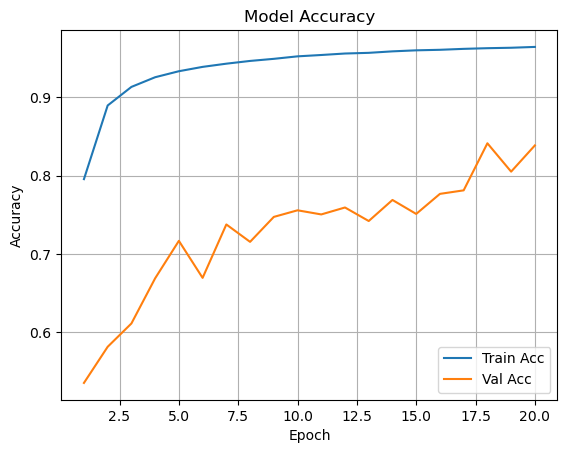

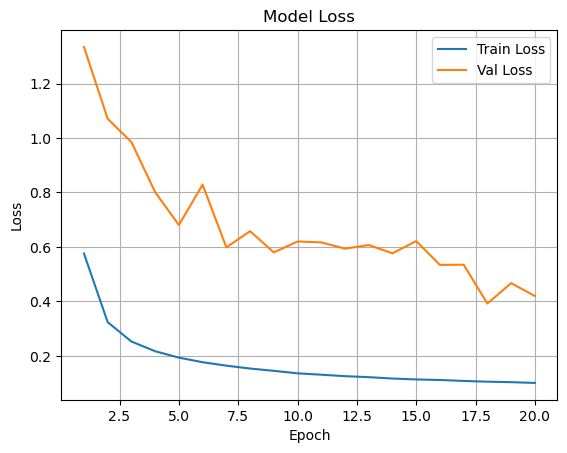

In [22]:
# Visualizing to compare the train model accuracy/loss to validation accuracy/loss
def plot_learningCurve(history):
    # Automatically use the number of epochs from history
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Accuracy
    plt.plot(epochs, history.history['accuracy'], label='Train Acc')
    plt.plot(epochs, history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_learningCurve(history)

### 3. Prediction and Evaluation Of Test Data

1640/1640 [==============================] - 12s 7ms/step
Accuracy: 0.9120
Classification Report:
                 precision    recall  f1-score   support

         Bowing       0.75      0.75      0.75         4
Carrying object       0.71      0.63      0.67       143
       Drinking       0.92      0.98      0.95       518
         Eating       0.63      0.81      0.71      1331
      Galloping       0.65      0.77      0.71        87
        Jumping       0.69      0.71      0.70        31
    Lying chest       0.94      0.94      0.94      8250
         Pacing       0.86      0.89      0.87       618
        Panting       0.83      0.89      0.86      6687
        Playing       0.94      0.92      0.93      6901
        Shaking       0.87      0.96      0.91       329
        Sitting       0.89      0.80      0.84      4076
       Sniffing       0.98      0.99      0.99      8207
       Standing       0.85      0.74      0.79      3590
       Trotting       0.97      0.96      0.96

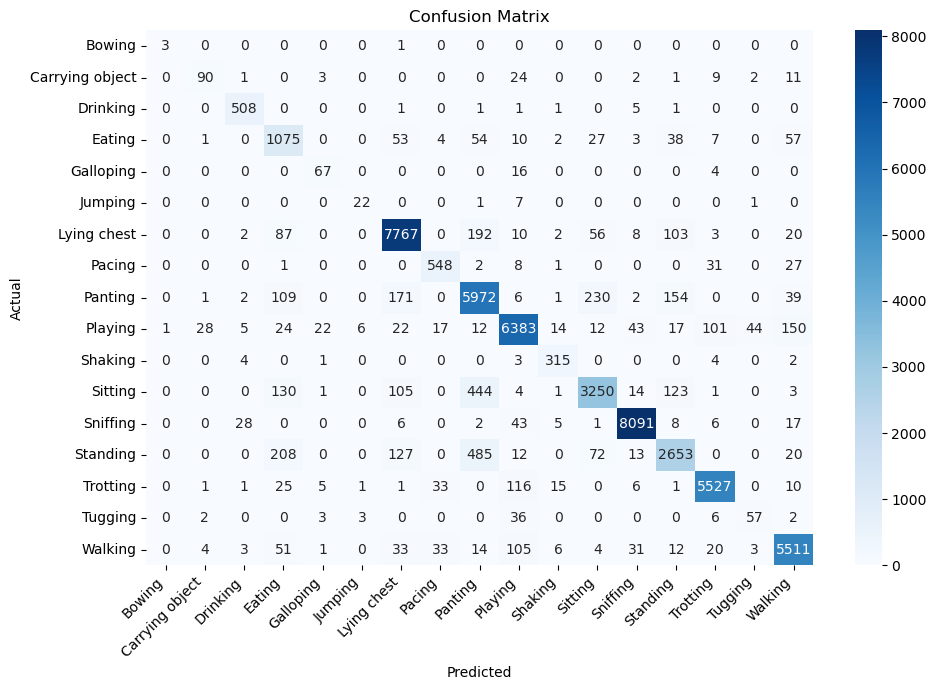

In [23]:
# Load the saved model
model = load_model('models/dog_movement_model.h5')

# Load test data
X_seq_test = np.load('X_seq_test.npy')
X_meta_test = np.load('X_meta_test.npy')
y_test = np.load('y_test.npy')

# Load label encoder
le = joblib.load('labelencoder.pkl')

# Make predictions
y_pred_probs = model.predict([X_seq_test, X_meta_test])
y_pred = np.argmax(y_pred_probs, axis=1)

# Decode predictions and true labels
y_pred_labels = le.inverse_transform(y_pred)
y_true_labels = le.inverse_transform(y_test)


# Accuracy score
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()